<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/seed_variantonly_stresstest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

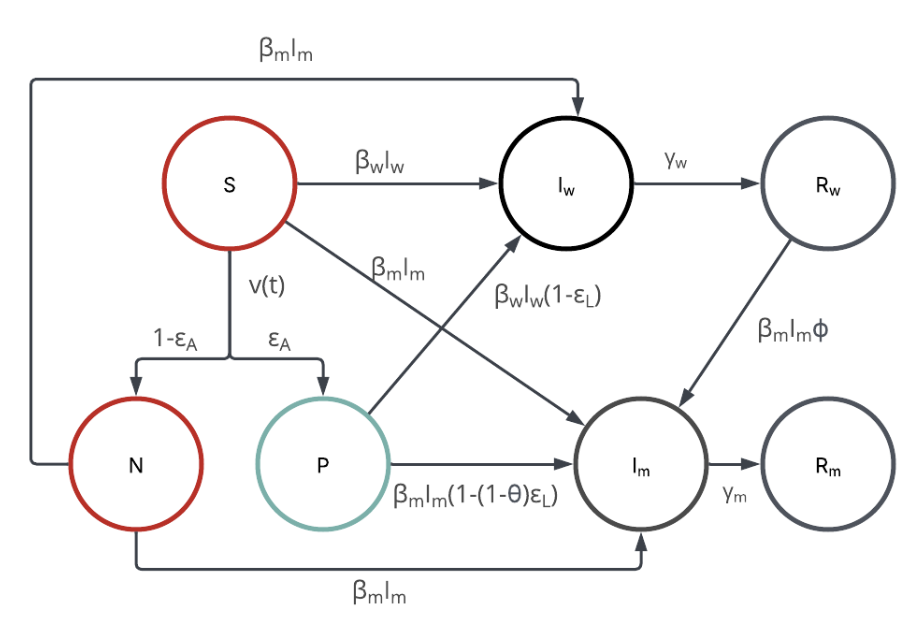

* for the most part keep theta and psi the same
* maybe do *some* scenarios where you have one extreme or another
* don't do every possibl e


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

CIw0 = 0
CIm0 = 0

In [2]:
# SIR model equations

def instant_vacc_SIR(t, y, phi, theta, betaw, gammaw, betam, gammam, epsilonL):
    """
    Modified SIR model for instant vaccination.
    """
    S, Iw, Rw, N, P, Im, Rm, CIw, CIm  = y

    dSdt = -(betaw*Iw+ betam*Im) * S #susceptible #note no v(t) because its incorporated into the 'seeding'
    dIwdt = betaw * Iw* (S + N + (1-epsilonL)*P) - gammaw * Iw #infections, wildtype
    dRwdt = gammaw * Iw - betam*Im*phi*Rw #recovered, wildtype

    dNdt = -(betam*Im + betaw*Iw) * N #no protection from vaccine
    dPdt =  -betaw*Iw*(1-epsilonL)*P - betam*Im*(1-((1-theta)*epsilonL))*P #some level of protection from vaccine

    dImdt = betam*Im*(S + N + phi*Rw + (1-((1-theta)*epsilonL))*P) - gammam * Im #infected mutants
    dRmdt = gammam * Im #recovered mutants

    dCIwdt = betaw * Iw* (S + N + (1-epsilonL)*P) #cumulative wildtype
    dCImdt = betam*Im*(S + N + phi*Rw + (1-((1-theta)*epsilonL))*P) #cumulative mutant

    return [dSdt, dIwdt, dRwdt, dNdt, dPdt, dImdt, dRmdt, dCIwdt, dCImdt]



In [3]:
# basic plot to show compartment prevalence across time
def plot_basic(solution_t, solution_y, ax=None, title="SIR sim w variant", ylim_max = 1, includeRt = False):
    if ax is None:
        fig, ax = plt.subplots(figsize = (10,6))

    t_full = solution_t

    S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y

    ax.plot(t_full, S, label='Susceptible')
    ax.plot(t_full, Iw, label='Infected (wildtype)')
    ax.plot(t_full, Im, label='Infected (mutant)')
    ax.plot(t_full, Rw, label='Recovered (wildtype)')
    ax.plot(t_full, N, label='Vaccinated, none')
    ax.plot(t_full, P, label='Vaccinated, no/partial/perfect')

    if includeRt == True:
      Rtw, Rtm = calc_Rts(S, N, P, Rw)

      ax.plot(t_full, Rtw, label='Rt of wildtype', linestyle = 'dashed')
      ax.plot(t_full, Rtm, label='Rt of mutant', linestyle = 'dashed')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population')
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax

def plot_infecteds(solution_t, solution_y, ax=None, title="two_strain, infecteds only", ylim_max = 0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize = (10,6))

    t_full = solution_t
    S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y

    ax.plot(t_full, Iw, label='Infected (wildtype)')
    ax.plot(t_full, Im, label='Infected (mutant)')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population')
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax

def plot_cums(solution_t, solution_y, ax=None, title="two_strain, infecteds only", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots(figsize = (10,6))

    t_full = solution_t
    S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y

    ax.plot(t_full, CIw, label='Infected (wildtype)')
    ax.plot(t_full, CIm, label='Infected (mutant)')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population')
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax


def calc_Rts(S, N, P, Rw):

  Rtw = []
  Rtm = []

  for i in range(len(S)):
    Rtw.append(Rwnaught*(S[i]+N[i]+(P[i]*(1-epsilonL))))
    Rtm.append(Rmnaught*(S[i]+N[i]+(P[i]*(1-(1-theta)*epsilonL))+phi*Rw[i]))

  return(Rtw, Rtm)



In [4]:
def _reach_size(t, y, phi, theta, betaw, gammaw, betam, gammam, epsilonL):
    return (y[2]) - recovered_threshold #its all vacc ppl

_reach_size.terminate = True

#FUNCTION TO FIND TIME OF VARIANT RISING
def find_tv(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL):
  sol_findtv = solve_ivp(instant_vacc_SIR, [0,t], y0,
                  args=(phi, theta, betaw, gammaw, betam, gammam, epsilonL),
                  events=_reach_size,
                  t_eval = np.linspace(0, t, t)) #changed dense output to np.linspace

  if len(sol_findtv.t_events[0]) == 0:
      return None   # or np.nan

  # get tv and seed Iv
  tv = np.ravel(np.array(sol_findtv.t_events))[0]

  return tv

def solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL):
  tv = find_tv(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)
  print(f"tv = {tv}")

  if tv == None:
    sol_full = solve_ivp(instant_vacc_SIR, [0,t], y0,
                  args=(phi, theta, betaw, gammaw, betam, gammam, epsilonL),
                  t_eval = np.linspace(0, t, t))

    y_full = sol_full.y
    t_full = sol_full.t

  else:

    sol1 = solve_ivp(instant_vacc_SIR, [0,tv], y0,
                    args=(phi, theta, betaw, gammaw, betam, gammam, epsilonL),
                    t_eval = np.linspace(0, tv, t))

    #last timepoint at tv
    y_tv = sol1.y[:, -1]
    print(f"y_tv S = {y_tv[0]}")
    print(f"y_tv Rw = {y_tv[2]}")

    #seed small fraction from Iw into Im
    y_tv[1] -= fraction_seed
    y_tv[5] += fraction_seed

    #second part of solution, after tv
    sol2 = solve_ivp(
        instant_vacc_SIR,
        [tv, t], # start at tv
        y_tv, # use updated initial condition
        args=(phi, theta, betaw, gammaw, betam, gammam, epsilonL),
        t_eval = np.linspace(tv, t, t)
    )

    #make into one full soln
    t_full = np.concatenate([sol1.t, sol2.t])
    y_full = np.hstack([sol1.y, sol2.y])

  return([t_full, y_full])

def find_finalCIw(solution_y):
  S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y
  return(CIw[-1])

def find_finalCIm(solution_y):
  S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y
  return(CIm[-1])

def Iw_wave_or_end(solution_y):
  S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y

  if Iw[-1] > 0.0002: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"

def Im_wave_or_end(solution_y):
  S, Iw, Rw, N, P, Im, Rm, CIw, CIm = solution_y

  if Im[-1] > 0.02: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"



In [5]:
def solve_ts(ts: list, t_types: list, phi: float, theta: float,betaw: float, gammaw: float,
                       betam: float, gammam: float, epsilonL: float, y_start: list):
  """
  Solves for t_start to tm, seeds mutant, then solves tm to t_end. Can be used with 'start' and 'end' being a different t
  """
  sols_y = []
  sols_t = []
  y_last = y_start

  for i in range(len(ts)-1):
    temp_sol = solve_ivp(instant_vacc_SIR, [ts[i],ts[i+1]], y_last,
                    args=(phi, theta, betaw, gammaw, betam, gammam, epsilonL),
                    t_eval = np.linspace(ts[i], ts[i+1], ts[i+1]-ts[i]))

    #last timepoint at tm
    y_last = sol1.y[:, -1]

    #WRITE SEEDING FUNCTION
    print("seeded")
    sols_y.append(temp_sol.y)
    sols_t.append(temp_sol.y)


  #make into one full soln
  #DO IT SMWHERE

  return([sols_y, sols_t])

#SEEDED TWO STRAIN MODELS W/O VACCINE ESCAPE

No advantage, they all do quite poorly...

## NO VACCINATION

###1. no vaccination, no immune escape.

Second strain does not do very well as no competitive advantage exists when there's no vaccines, so no escape. If seeded during peak, may not show up at all.

Epsilons do not matter. Phi matters due to immune escape, so in this case, phi = 0

Final epidemic size is affected by R0. If R0 is kept constant (and no interactions with other strains...), changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indirectly affected by R0 and recovery rate. This was confirmed for second strain in absence of first.

tv = 75.29335236738417
y_tv S = 0.6860935154624088
y_tv Rw = 0.14991796397574278


<Axes: title={'center': 'two strain, no vacc'}, xlabel='Time (days)', ylabel='Proportion of Population'>

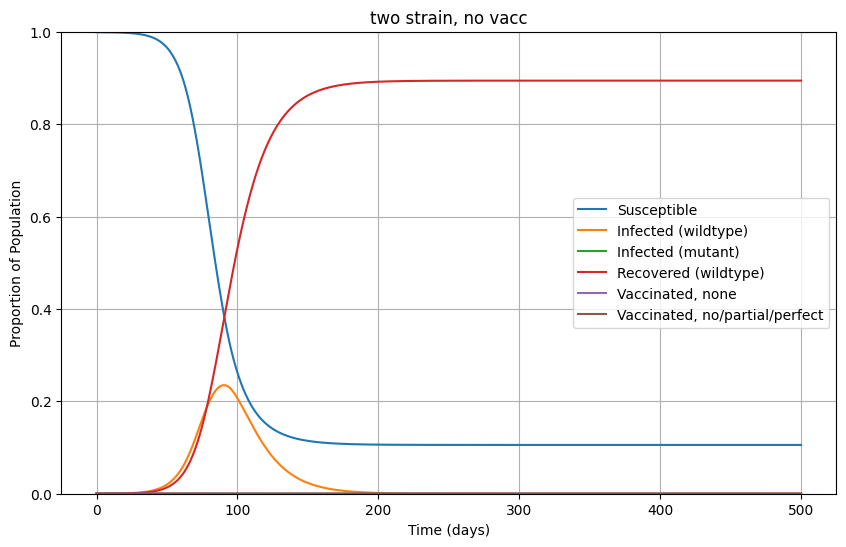

In [6]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = np.random.rand()
epsilona = np.random.rand()
epsilonL = np.random.rand()
t = 500


# set initial conditions
S0 = 0.999
Iw0 = 0.0001

Rw0 = 0
Rm0 = 0
Im0 = 0.0000

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]


recovered_threshold = 0.15
fraction_seed = 0.00001
t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


plot_basic(t_full, y_full, title = "two strain, no vacc")

###2. no vacc, imm escape of 0.5.

Second strain does better as there is competitive advantage, and likely peaks later. Recovered WT has to decrease at some point instead of just monotonic

Epsilons do not matter.

tv = 54.247054778813634
y_tv S = 0.6565935523838451
y_tv Rw = 0.14997088300347347


<Axes: title={'center': 'two strain, no vacc'}, xlabel='Time (days)', ylabel='Proportion of Population'>

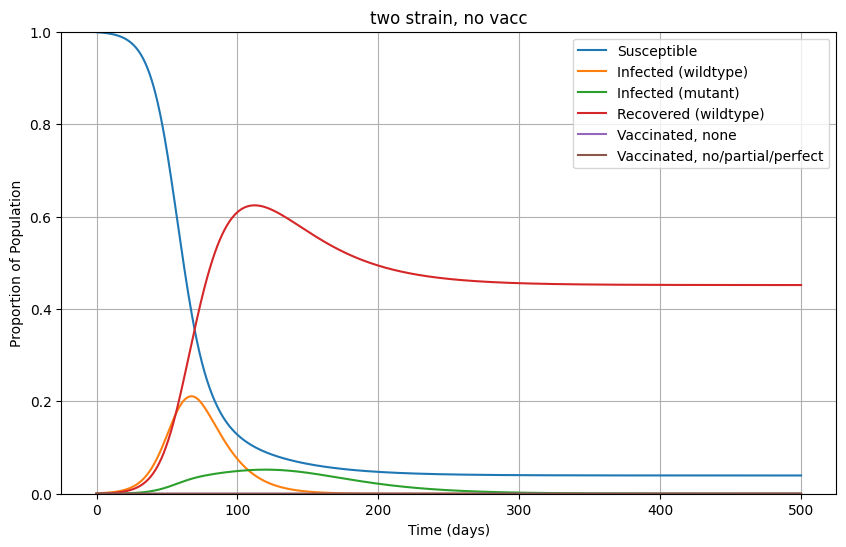

In [7]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0.5
theta = np.random.rand()
epsilona = np.random.rand()
epsilonL = np.random.rand()
t = 500


# set initial conditions
S0 = 0.999
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0.0001

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#part of find tv
recovered_threshold = 0.15
fraction_seed = 0.0001
t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)

plot_basic(t_full, y_full, title = "two strain, no vacc")

## SOME VACCINATION

Unless there is escape, second strain does not do very well, since it enters late with low Rt. Check to make sure Rt is low when variant enters

###1.0 VC = 0.3, VE = 1, no immune escape, everything goes to P.

VC = vaccine coverage
Second strain does not do very well as no competitive advantage and many susceptibles are already unsusceptible

Epsilons are both 1, for perfect protection. Phi, theta matters due to immune, vaccine escape, so in this case, phi, theta = 0.

tv = 97.61030456444097
y_tv S = 0.480562495308454
y_tv Rw = 0.14982265061537084


<Axes: title={'center': 'two strain, vacc, no escape, smaller y_axis max'}, xlabel='Time (days)', ylabel='Proportion of Population'>

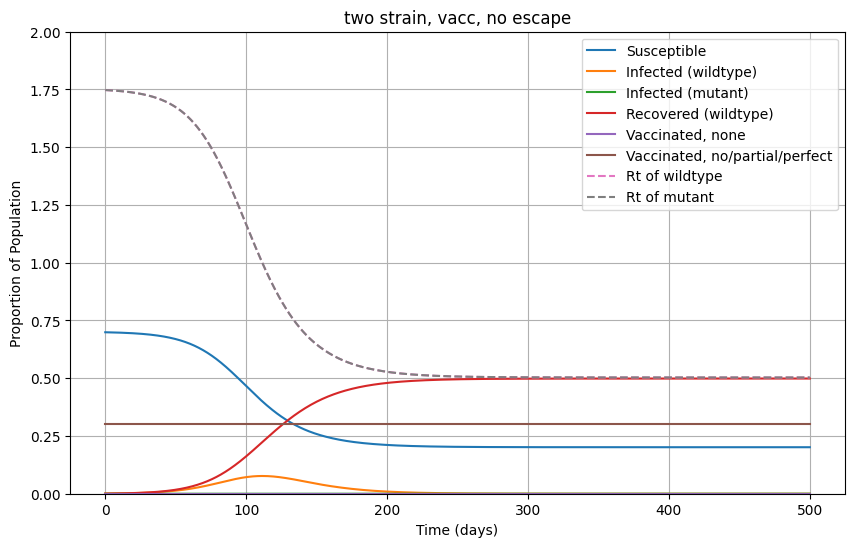

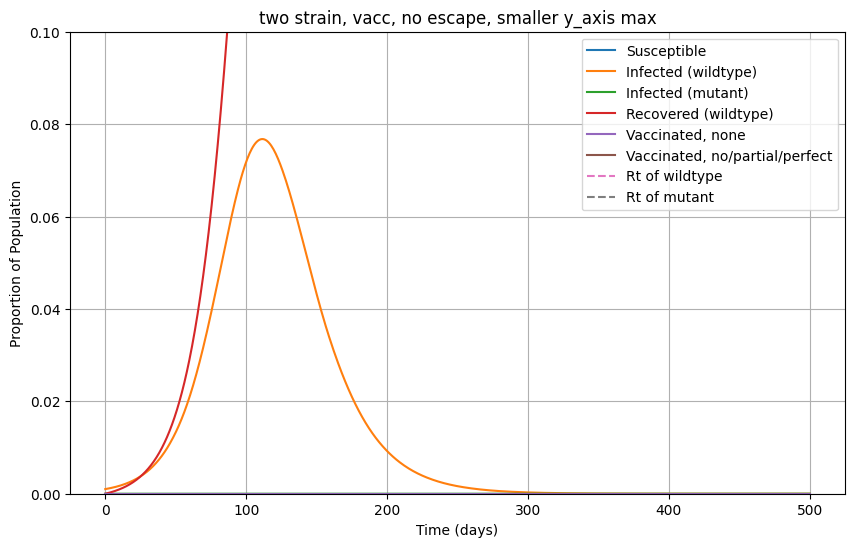

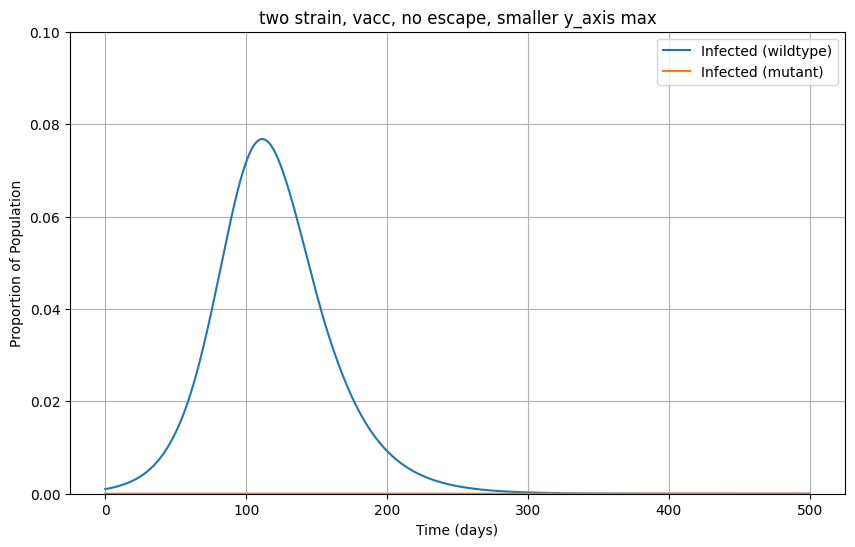

In [8]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0
epsilona = 1
epsilonL = 1
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#part of find tv
recovered_threshold = 0.15
fraction_seed = 0.00001
t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)

plot_basic(t_full, y_full, title = "two strain, vacc, no escape", includeRt= True, ylim_max = 2)
plot_basic(t_full, y_full, title = "two strain, vacc, no escape, smaller y_axis max", ylim_max = 0.10,  includeRt= True)
plot_infecteds(t_full, y_full, title = "two strain, vacc, no escape, smaller y_axis max", ylim_max = 0.10)

###2.0. VC = 0.3, VE = 0, no immune escape, vaccine is useless everything goes to N.

VC = vaccine coverage
Essentially the same as the first unseeded two strain scenario, but the susceptibles are split between S and N
Second strain does not do very well as no competitive advantage, and likely peaks around the same time.

Eps_a = 0, eps_L does not matter. Phi, theta matters due to immune, vaccine escape, so in this case, phi, theta = 0, aka no escape

tv = 53.75735226009112
y_tv S = 0.48025676909783144
y_tv Rw = 0.15006813229941338
tv = 53.757410575482034
y_tv S = 0.6863743954917307
y_tv Rw = 0.1500688127703037


<Axes: title={'center': 'tw strain, no vacc'}, xlabel='Time (days)', ylabel='Proportion of Population'>

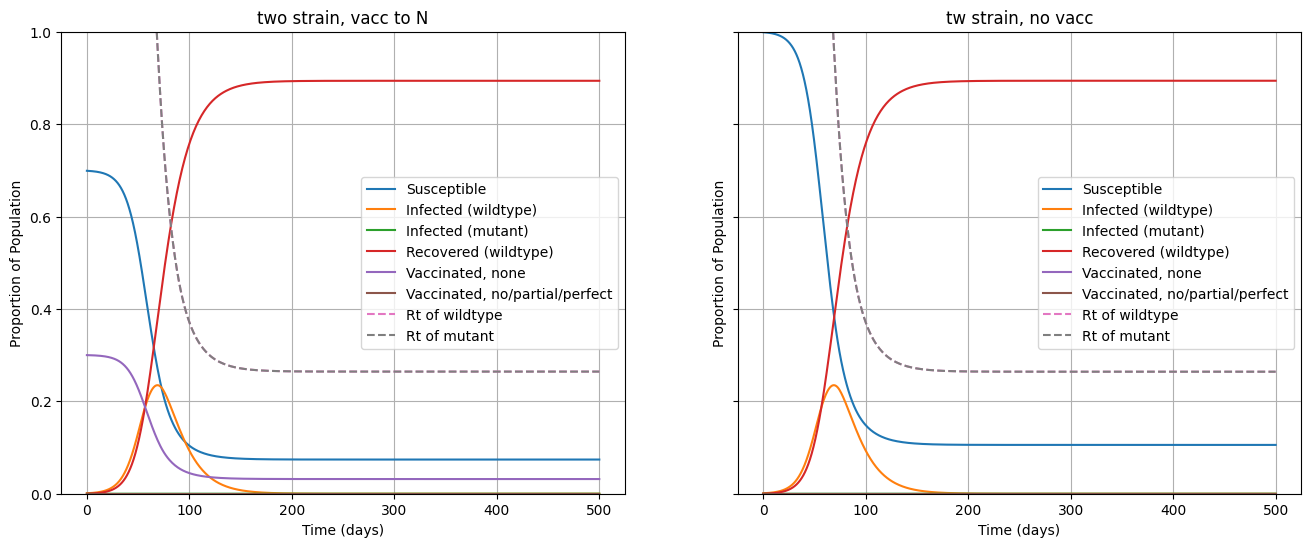

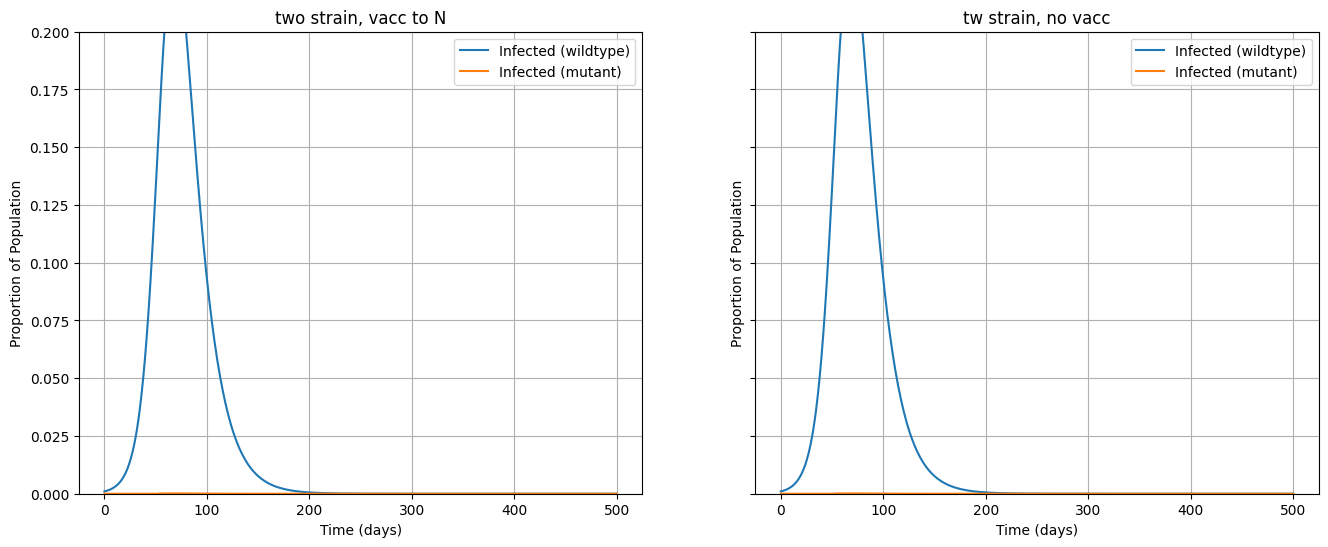

In [9]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0
epsilona = 0
epsilonL = np.random.rand()
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")

recovered_threshold = 0.15
fraction_seed = 0.0001


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]
t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


# to compare with no vaccination version, to make sure same final epidemic size
S0 = 0.699+N0+P0
N0 = 0
P0 = 0

y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

t_full_nv, y_full_nv = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

plot_basic(t_full, y_full, title = "two strain, vacc to N", includeRt = True, ax = axes[0])
plot_basic(t_full_nv, y_full_nv, title = "tw strain, no vacc", ax = axes[1], includeRt = True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

plot_infecteds(t_full, y_full, title = "two strain, vacc to N", ax = axes[0])
plot_infecteds(t_full_nv, y_full_nv, title = "tw strain, no vacc", ax = axes[1])

###2.5. pt. 2 VC = 0.3, VE = 0, no immune escape, vaccine is useless everything goes to P with 0 protection.

VC = vaccine coverage
Essentially the same as the previous unseeded + the first two strain scenario, but the susceptibles are split between S and P
Second strain does not do very well as no competitive advantage, and likely peaks around the same time.

Eps_a = 1, eps_L = 0. Phi, theta matters due to immune, vaccine escape, so in this case, phi, theta = 0, aka no escape

tv = 53.75735226009112
y_tv S = 0.48025676909783144
y_tv Rw = 0.15006813229941338
tv = 53.757410575482034
y_tv S = 0.6863743954917307
y_tv Rw = 0.1500688127703037


<Axes: title={'center': 'two strain, vacc to P (no imm)'}, xlabel='Time (days)', ylabel='Proportion of Population'>

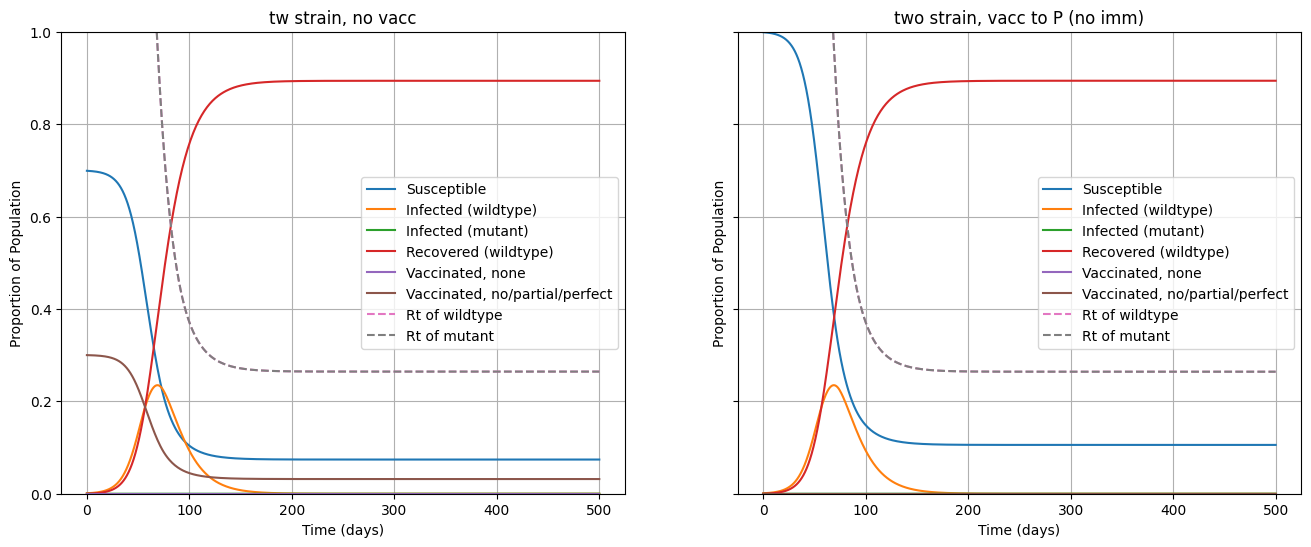

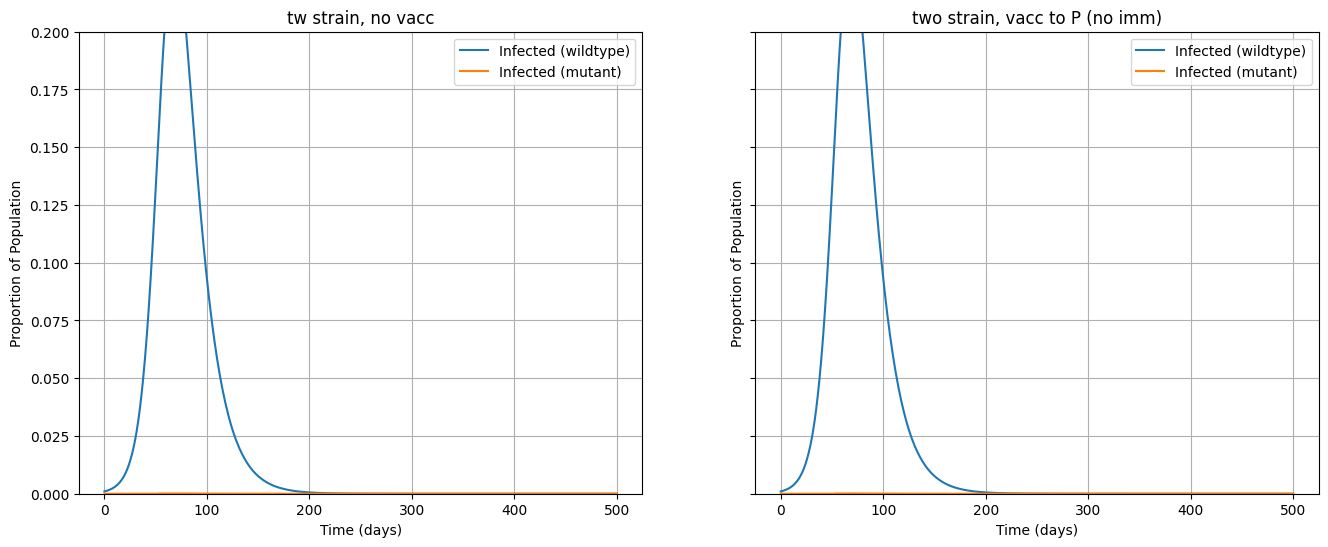

In [10]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0
epsilona = 1
epsilonL = 0
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]
recovered_threshold = 0.15
fraction_seed = 0.0001


t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


# to compare with no vaccination version, to make sure same final epidemic size
S0 = 0.699+N0+P0
N0 = 0
P0 = 0

y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]


t_full_nv, y_full_nv = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plot_basic(t_full, y_full, title = "tw strain, no vacc", ax = axes[0], includeRt = True)
plot_basic(t_full_nv, y_full_nv, title = "two strain, vacc to P (no imm)", ax = axes[1], includeRt = True)



fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plot_infecteds(t_full, y_full, title = "tw strain, no vacc", ax = axes[0])
plot_infecteds(t_full_nv, y_full_nv, title = "two strain, vacc to P (no imm)", ax = axes[1])



###**3.0 VC = 0.3, VE = 0.5. Leaky and AoN for sake of comparison

LEAKY:
P as the leaky vaccinated compartment, epsilon_L = 0.5, epsilon_a = 1.

AoN:
epsilon_L = 1, epsilon_a = 0.5, so half get perfect and half get notthing.




#### COMMENT:
Mutant does poorly for reasons mentioned above. Note how effective reproductive number is lower from the start for leaky vaccine...

tv = 68.28248965917908
y_tv S = 0.4801577240966233
y_tv Rw = 0.1501688016411235
tv = 68.76488546282829
y_tv S = 0.48017599881155076
y_tv Rw = 0.1501547970239633


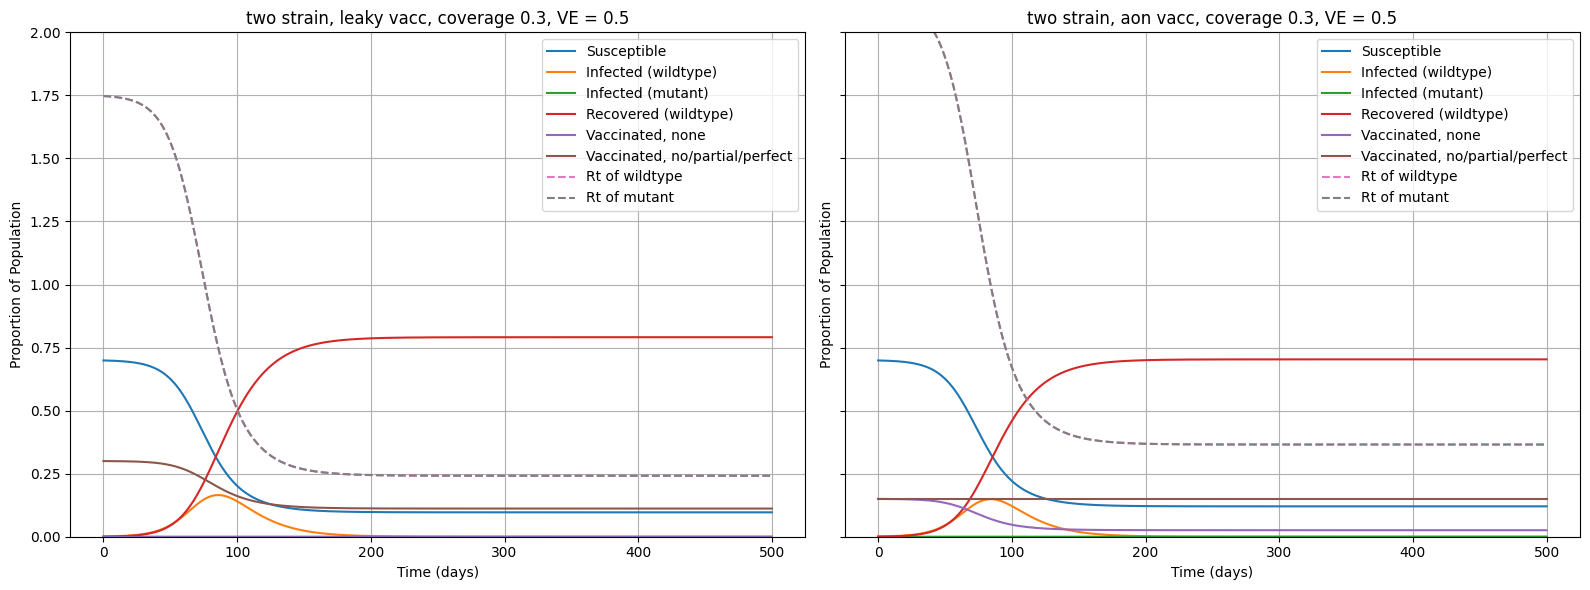

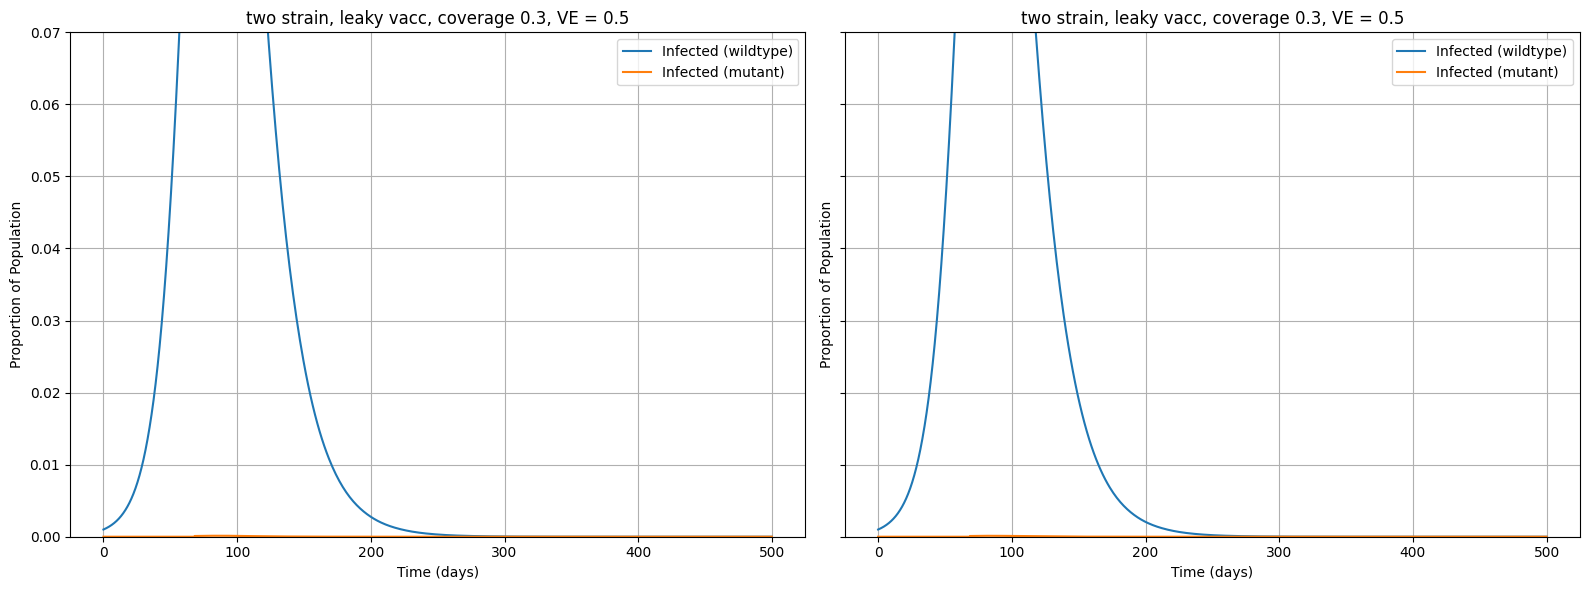

In [11]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0
epsilona = 1
epsilonL = 0.5
t = 500

recovered_threshold = 0.15
fraction_seed = 0.0001

# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#leaky

t_full_leaky, y_full_leaky = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


#aon, so epislona and epsilonL changes, meaning N/P change
epsilona = 0.5
epsilonL = 1
N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

t_full_aon, y_full_aon = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

#FIGURE OUT MATPOTKIB
plot_basic(t_full_leaky, y_full_leaky, title = "two strain, leaky vacc, coverage 0.3, VE = 0.5", ax = axes[0], ylim_max = 2, includeRt = True)
plot_basic(t_full_aon, y_full_aon, title = "two strain, aon vacc, coverage 0.3, VE = 0.5", ax = axes[1], ylim_max = 2, includeRt = True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plot_infecteds(t_full_leaky, y_full_leaky, title = "two strain, leaky vacc, coverage 0.3, VE = 0.5", ax = axes[0], ylim_max = 0.07)
plot_infecteds(t_full_aon, y_full_aon, title = "two strain, leaky vacc, coverage 0.3, VE = 0.5", ax = axes[1], ylim_max = 0.07)

plt.tight_layout()
plt.show()


###4.0. VE = 0.5, intermediate 2 vaccine failure modes: leaky and no natural immunity. VE = 0.5, so 0.75 and 0.6666 repeating

Somewhere in between prev two models... Vaccinated with partial protection starts off higher, both should decrease though

Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

tv = 68.28248965917908
y_tv S = 0.4801577240966233
y_tv Rw = 0.1501688016411235
tv = 68.76488546282829
y_tv S = 0.48017599881155076
y_tv Rw = 0.1501547970239633
tv = 68.43750046141784
y_tv S = 0.48016331893391806
y_tv Rw = 0.1501645144706078


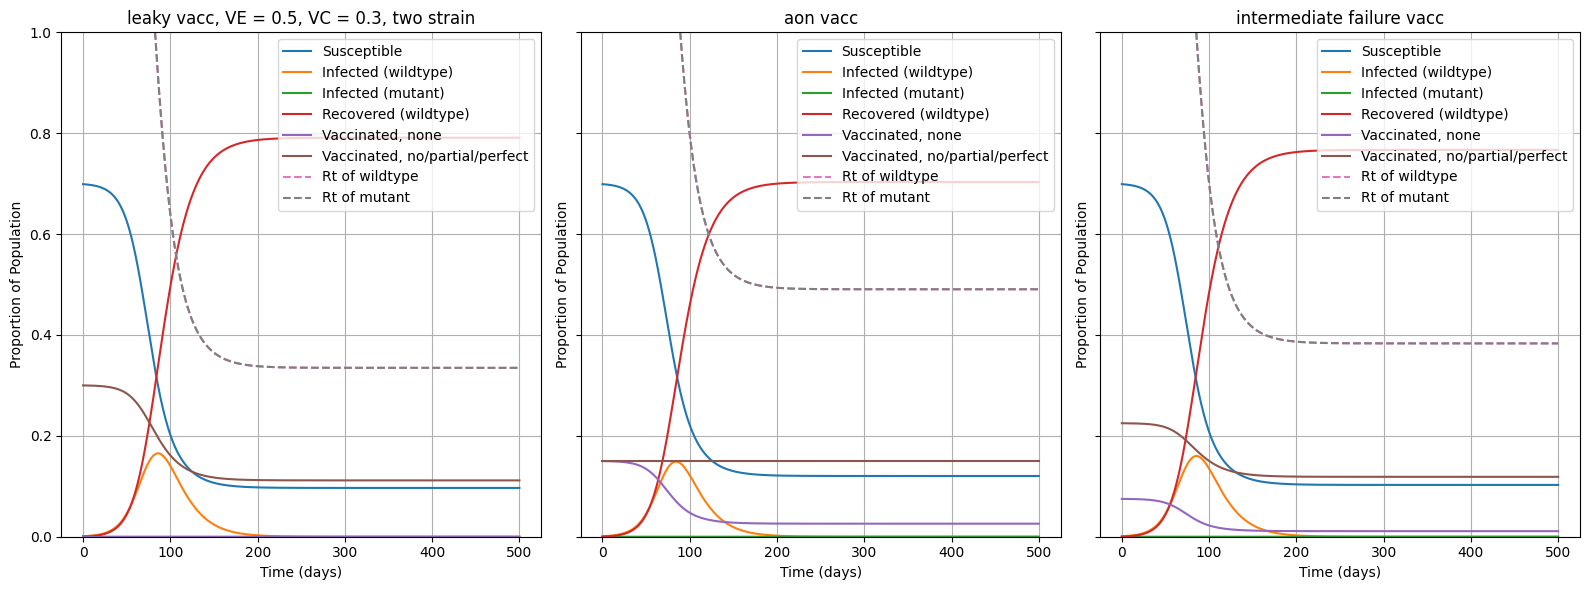

In [12]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

#leaky first
phi = 0
theta = 0
epsilona = 1
epsilonL = 0.5
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#leaky
t_full_leaky, y_full_leaky = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)



#aon, so epislona and epsilonL changes, meaning N/P change
epsilona = 0.5
epsilonL = 1
N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]


t_full_aon, y_full_aon = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)



#intermediate, so epislona and epsilonL changes, meaning N/P change
epsilona = 0.75
epsilonL = 0.5/0.75
N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

t_full_inter, y_full_inter = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)



fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

plot_basic(t_full_leaky, y_full_leaky, title = "leaky vacc, VE = 0.5, VC = 0.3, two strain", ax = axes[0], includeRt=True)
plot_basic(t_full_aon, y_full_aon, title = "aon vacc", ax = axes[1], includeRt=True)
plot_basic(t_full_inter, y_full_inter, title = "intermediate failure vacc", ax = axes[2], includeRt=True)

plt.tight_layout()
plt.show()

# VACCINE ESCAPE MODELS

Going to do scenarios above with vaccine escape...

#### 1.0 VE = 1, VC = 0.3, , immune escape = phi = 0, theta = 0.5, everything goes to P.


seems like infected mutant is very small unless its R0 is much greater than the wild type when it arrives at recovered threshold



tv = 86.50888162712964
y_tv S = 0.5445224214231137
y_tv Rw = 0.09984116348731097
tv = 86.50888162712964
y_tv S = 0.5445224214231137
y_tv Rw = 0.09984116348731097


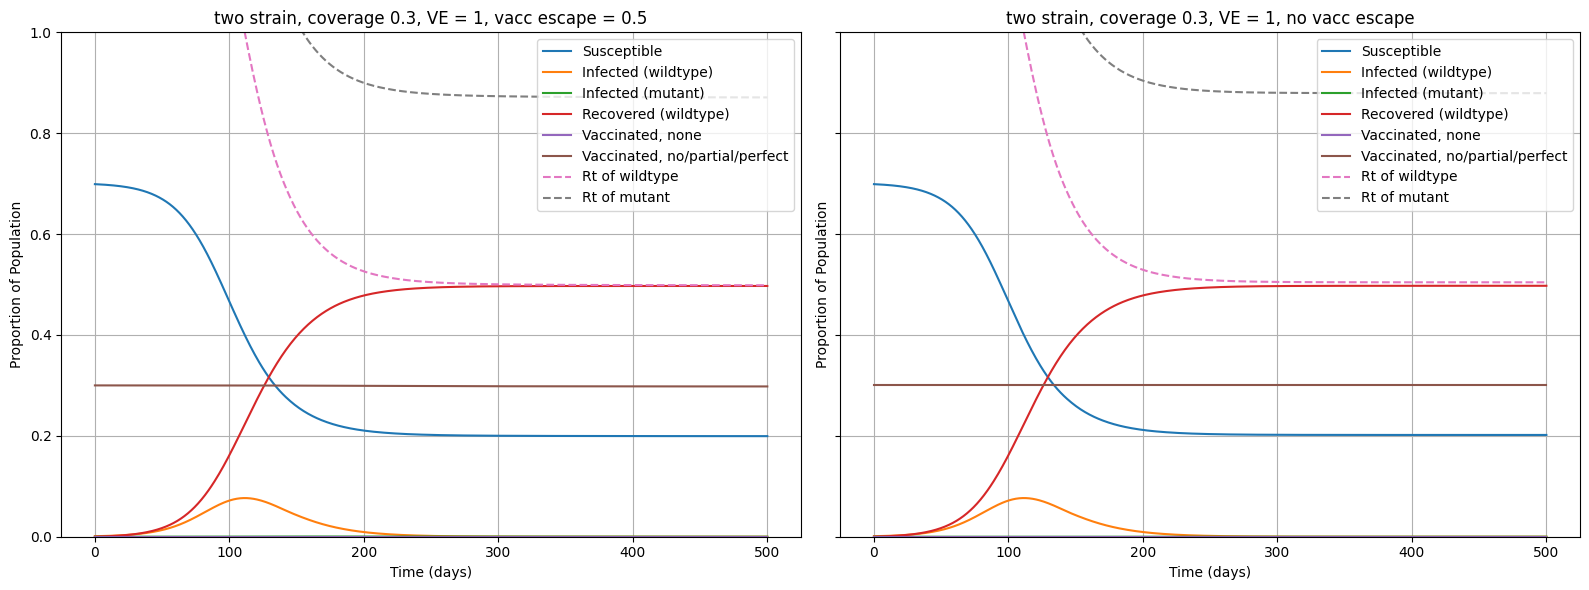

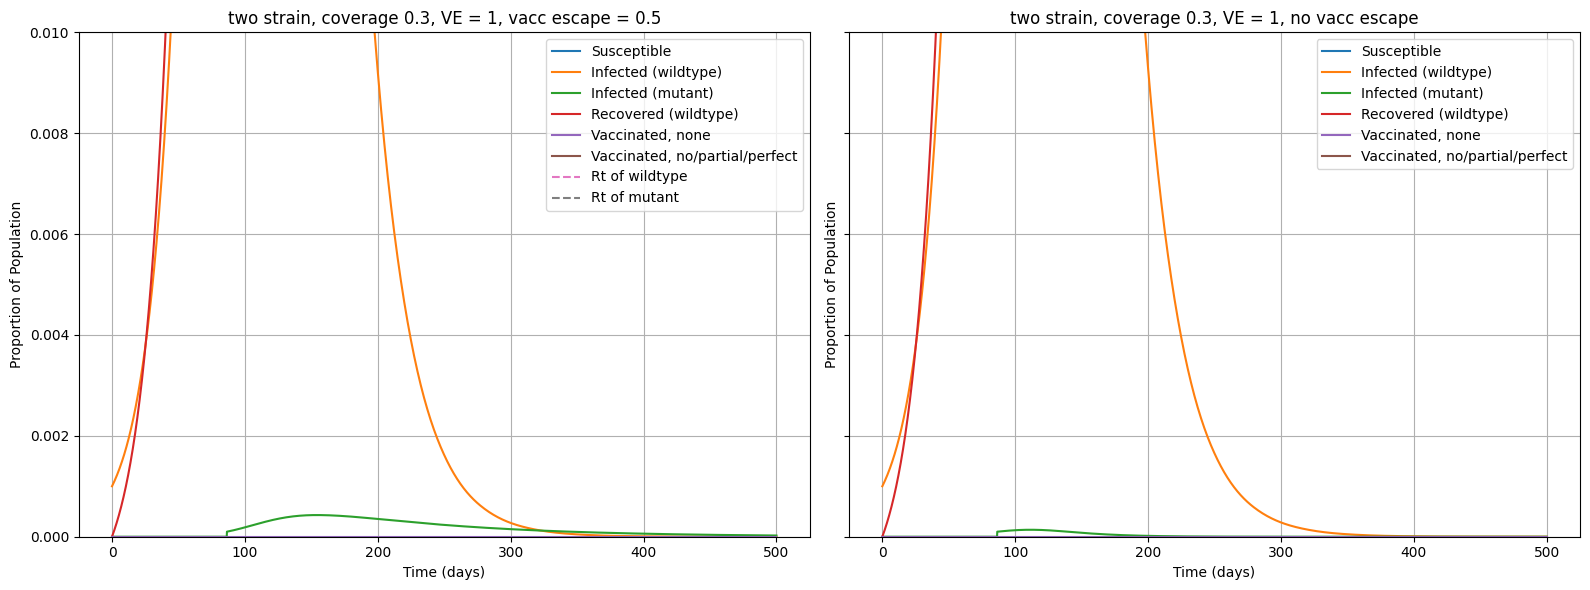

<Axes: title={'center': 'two strain, coverage 0.3, VE = 1, no vacc escape'}, xlabel='Time (days)', ylabel='Proportion of Population'>

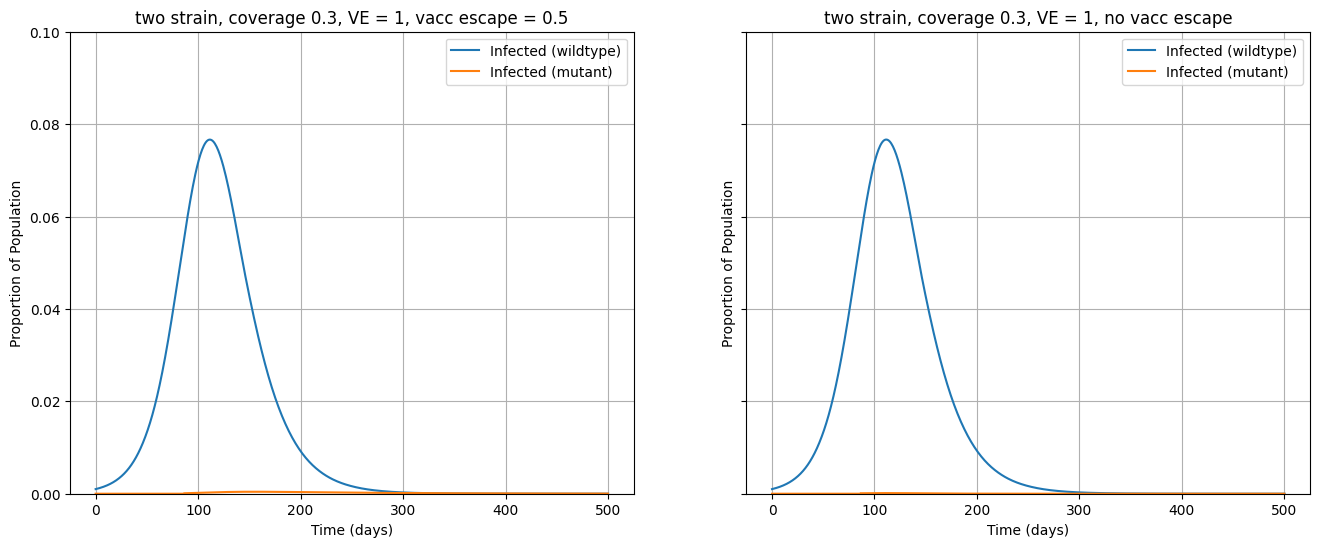

In [19]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0.5
epsilona = 1
epsilonL = 1
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")

y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#part of find tv
recovered_threshold = 0.1
fraction_seed = 0.0001

t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)
t_full_nve, y_full_nve = solve_seeded(t, phi, 0, betaw, gammaw, betam, gammam, epsilonL)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

#FIGURE OUT MATPOTKIB
plot_basic(t_full, y_full, title = "two strain, coverage 0.3, VE = 1, vacc escape = 0.5",
           ax = axes[0], ylim_max = 1, includeRt = True)
plot_basic(t_full_nve, y_full_nve, title = "two strain, coverage 0.3, VE = 1, no vacc escape",
           ax = axes[1], ylim_max = 1, includeRt = True)

plt.tight_layout()
plt.show()

#close up plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

plot_basic(t_full, y_full, title = "two strain, coverage 0.3, VE = 1, vacc escape = 0.5",
           ax = axes[0], ylim_max = 1, includeRt = True)
plot_basic(t_full_nve, y_full_nve, title = "two strain, coverage 0.3, VE = 1, no vacc escape", ax = axes[1], ylim_max = 0.01)

plt.tight_layout()
plt.show()

#plot infected curves only
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plot_infecteds(t_full, y_full, ylim_max= 0.075,
               title = "two strain, coverage 0.3, VE = 1, vacc escape = 0.5",
               ax = axes[0])
plot_infecteds(t_full_nve, y_full_nve, ylim_max= 0.1, title = "two strain, coverage 0.3, VE = 1, no vacc escape", ax = axes[1])


#### 2.0 VE = 0, VC = 0.3, , immune escape = phi = 0, theta = 0.5, vaccine is useless and escape makes 0 difference

Epsilon_L makes no difference


tv = 53.75735226009112
y_tv S = 0.48025676909783144
y_tv Rw = 0.15006813229941338
tv = 53.757410575482034
y_tv S = 0.6863743954917307
y_tv Rw = 0.1500688127703037


<Axes: title={'center': 'tw strain, no vacc'}, xlabel='Time (days)', ylabel='Proportion of Population'>

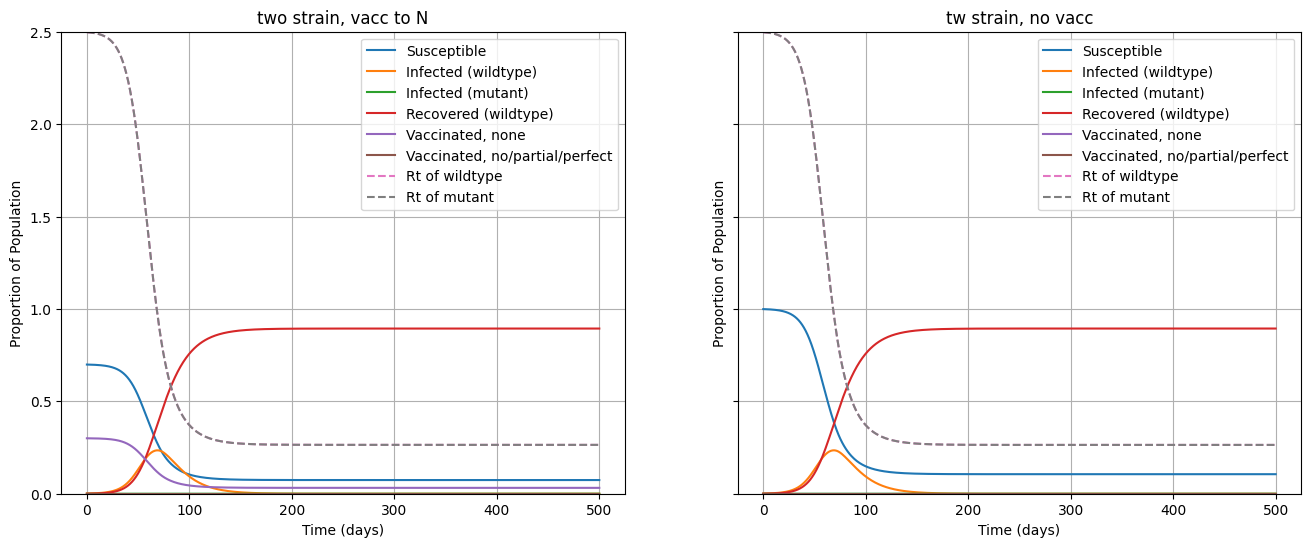

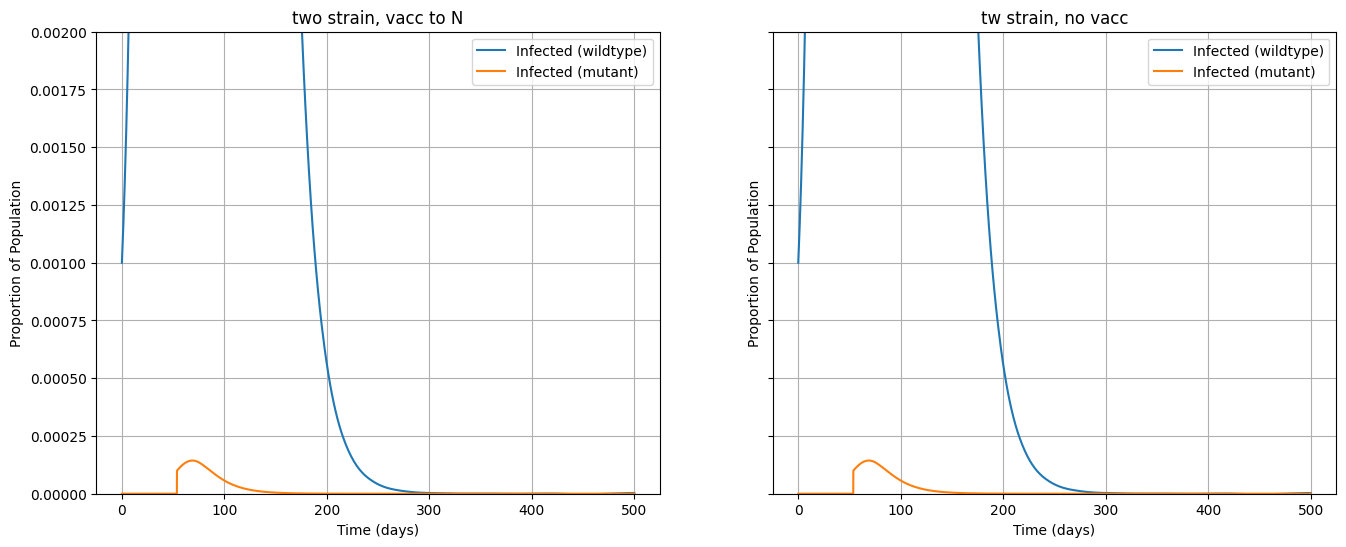

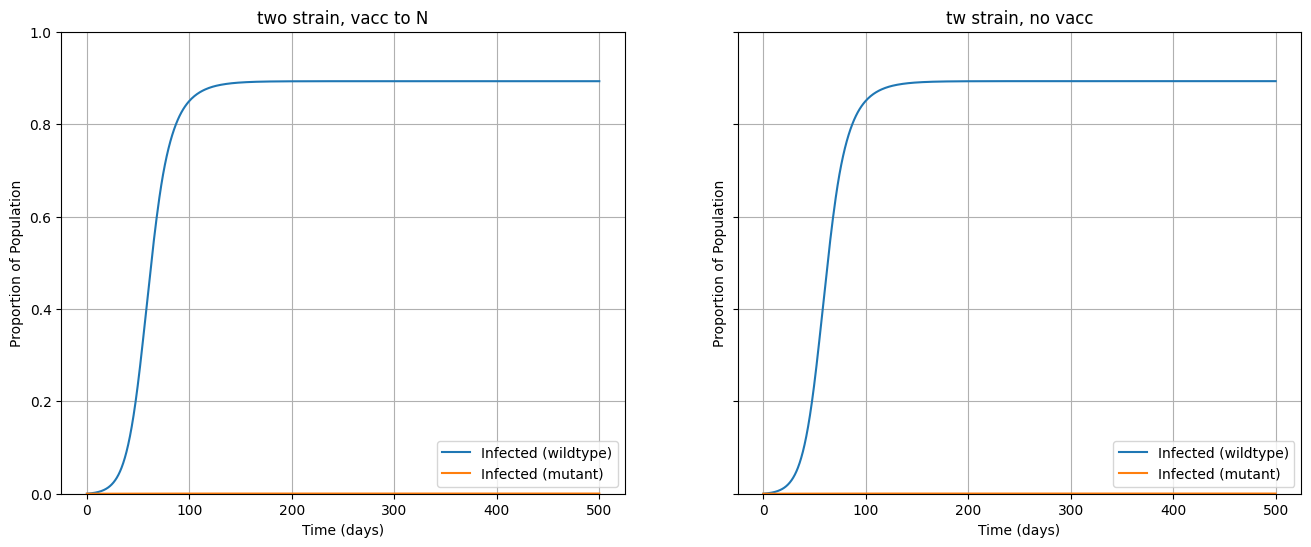

In [24]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0.5
epsilona = 0
epsilonL = np.random.rand()
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")

recovered_threshold = 0.15
fraction_seed = 0.0001


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]
t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)


# to compare with no vaccination version, to make sure same final epidemic size
S0 = 0.699+N0+P0
N0 = 0
P0 = 0

y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

t_full_nv, y_full_nv = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)

#regular time series
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

plot_basic(t_full, y_full, title = "two strain, vacc to N", includeRt = True, ax = axes[0], ylim_max=2.5)
plot_basic(t_full_nv, y_full_nv, title = "tw strain, no vacc", ax = axes[1], includeRt = True, ylim_max=2.5)

#infected only
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

plot_infecteds(t_full, y_full, title = "two strain, vacc to N", ax = axes[0], ylim_max = 0.02)
plot_infecteds(t_full_nv, y_full_nv, title = "tw strain, no vacc", ax = axes[1], ylim_max = 0.002)

#cumulatives
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

plot_cums(t_full, y_full, title = "two strain, vacc to N", ax = axes[0])
plot_cums(t_full_nv, y_full_nv, title = "tw strain, no vacc", ax = axes[1])

### COMMENT

Rt reaches 1 but mutants continue...

#CALC RTs too

In [ ]:
S, Iw, Rw, N, P, Im, Rm, CIw, CIm = y_full_inter

In [ ]:
#Rt, via sus
Rtw_last1 = Rwnaught*(S[-1]+N[-1]+(P[-1]*(1-epsilonL)))

#Rt, via 1-imm
Rtw_last2 = Rwnaught*(1-(Iw[-1]+Rw[-1]+(epsilonL*P[-1])+Im[-1]+Rm[-1]))

print(Rtw_last1, Rtw_last2)


In [ ]:
Rtm_last1 = Rmnaught*(S[-1]+N[-1]+(P[-1]*(1-(1-theta)*epsilonL))+phi*Rw[-1])

Rtm_last2 = Rmnaught*(1-(Iw[-1] + (Rw[-1]*(1-phi)) + ((1-theta)*epsilonL)*P[-1] + Rm[-1] + Im[-1]))


print(Rtm_last1, Rtm_last2)

In [ ]:
(P[-1]*(1-(1-theta)*epsilonL))+phi*Rw[-1] #part of Rtm that Rtw doesnt have


In [ ]:
P[-1]*(1-epsilonL) #part of Rtw that Rtm doesnt have

In [ ]:
phi*Rw[-1]

In [ ]:
plot_basic(t_full, y_full, title = "two strain, coverage 0.3, VE = 0, vacc escape = 0.5", ylim_max = 0.001, includeRt=True)


####2.0 VE = 0. VC = 0.3, VE = 0.5. Vacc escape (0.5) should make 0 difference

Mutant strain seems to do v poorly considering no advantage and very low beforehand...Rt is low by the time it's seeded

In [ ]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 4
gammam = 1/14
betam = gammam*Rmnaught

phi = 0
theta = 0.5
epsilona = 0
epsilonL = np.random.rand()
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]
solution_34 = solve_ivp(instant_vacc_SIR, [0,t], y0,
                  args=(phi, theta, betaw, gammaw, betam, gammam, epsilonL),
                  t_eval = np.linspace(0, t, t))

# to compare with no vaccination version, to make sure same final epidemic size
S0 = 0.699+N0+P0
N0 = 0
P0 = 0

y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

recovered_threshold = 0.15
fraction_seed = 0.0001

t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)
t_full_nve, y_full_nve = solve_seeded(t, phi, 0, betaw, gammaw, betam, gammam, epsilonL)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

#FIGURE OUT MATPOTKIB
plot_basic(t_full, y_full, title = "two strain, coverage 0.3, VE = 0, vacc escape = 0.5", ax = axes[0], ylim_max = 1, includeRt=True)
plot_basic(t_full_nve, y_full_nve, title = "two strain, coverage 0.3, VE = 0, no vacc escape", ax = axes[1], ylim_max = 1)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plot_infecteds(t_full, y_full, title = "two strain, coverage 0.3, VE = 0, vacc escape = 0.5", ax = axes[0])
plot_infecteds(t_full_nve, y_full_nve, ylim_max= 0.2, title = "two strain, coverage 0.3, VE = 0, no vacc escape", ax = axes[1])






In [ ]:
plot_basic(t_full, y_full, title = "two strain, coverage 0.3, VE = 0, vacc escape = 0.5", ylim_max = 0.001, includeRt=True)


## VACCINATION + IMM. ESCAPE

###1.0 VE = 1, VC = 0.3, , immune escape = phi = 0.5, everything goes to P. Compared to no theta.

VC = vaccine coverage

Second strain has competitive advantage of immune escape, and likely peaks later than WT.

Epsilons are both 1, for perfect protection. Phi, theta matters due to immune, vaccine escape, so in this case, phi = 0.5, theta = 0.

In [ ]:
# set parameter values (except epsilon) for all scenarios
#betaw = 1.1
Rwnaught = 2.5
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = gammam*Rmnaught

phi = 0.5
theta = 0
epsilona = 1
epsilonL = 1
t = 500


# set initial conditions
S0 = 0.699
Iw0 = 0.001

Rw0 = 0
Rm0 = 0
Im0 = 0.0001

N0 = (1-epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))
P0 = (epsilona)*(1-(S0+Iw0+Rw0+Rm0+Im0))

#need to get this seeded later

if Iw0+S0+Rw0+N0+P0+Rm0+Im0 != 1:
  print("ERRORERROR")


y0 = [S0, Iw0, Rw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#part of find tv
recovered_threshold = 0.15
fraction_seed = 0.0001

t_full, y_full = solve_seeded(t, phi, theta, betaw, gammaw, betam, gammam, epsilonL)
t_full_nie, y_full_nie = solve_seeded(t, 0, theta, betaw, gammaw, betam, gammam, epsilonL)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

#FIGURE OUT MATPOTKIB
plot_basic(t_full, y_full, title = "two strain, coverage 0.3, VE = 0.5, imm escape = 0.5", ax = axes[0], ylim_max = 1, includeRt = True)
plot_basic(t_full_nie, y_full_nie, title = "two strain, coverage 0.3, VE = 0.5, no imm escape", ax = axes[1], ylim_max = 1, includeRt = True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plot_infecteds(t_full, y_full, title = "two strain, coverage 0.3, VE = 0.5, imm escape = 0.5", ax = axes[0])
plot_infecteds(t_full_nie, y_full_nie, title = "two strain, coverage 0.3, VE = 0.5, no imm escape", ax = axes[1])
